In [1]:
from typing import Union
from pathlib import Path
import warnings
from pprint import pprint
from glob import glob
import json, os
import collections as cl
from math import trunc
from operator import itemgetter
from dataclasses import dataclass
from joblib import Parallel, delayed

from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from box import Box
from sklearn.model_selection import KFold

import tifffile
import rasterio

In [2]:
PATH_ORG = '/workspace/sample/20APR04014122-S2AS_R1C1-015150647030_01_P001.TIF'
img_org = tifffile.imread(PATH_ORG)
img_org.shape

(4, 16384, 16384)

Num Patch 1352
(16384, 16384)


  0%|          | 0/1352 [00:00<?, ?it/s][ WARN:0@1158.510] global loadsave.cpp:248 findDecoder imread_('/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/20APR04014122-S2AS_R1C1-015150647030_01_P001_channel-last_13440_12800_14080_13440.png'): can't open/read file: check file path/integrity
[ WARN:0@1158.515] global loadsave.cpp:248 findDecoder imread_('/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/20APR04014122-S2AS_R1C1-015150647030_01_P001_channel-last_1920_13440_2560_14080.png'): can't open/read file: check file path/integrity
100%|██████████| 1352/1352 [00:02<00:00, 571.37it/s]


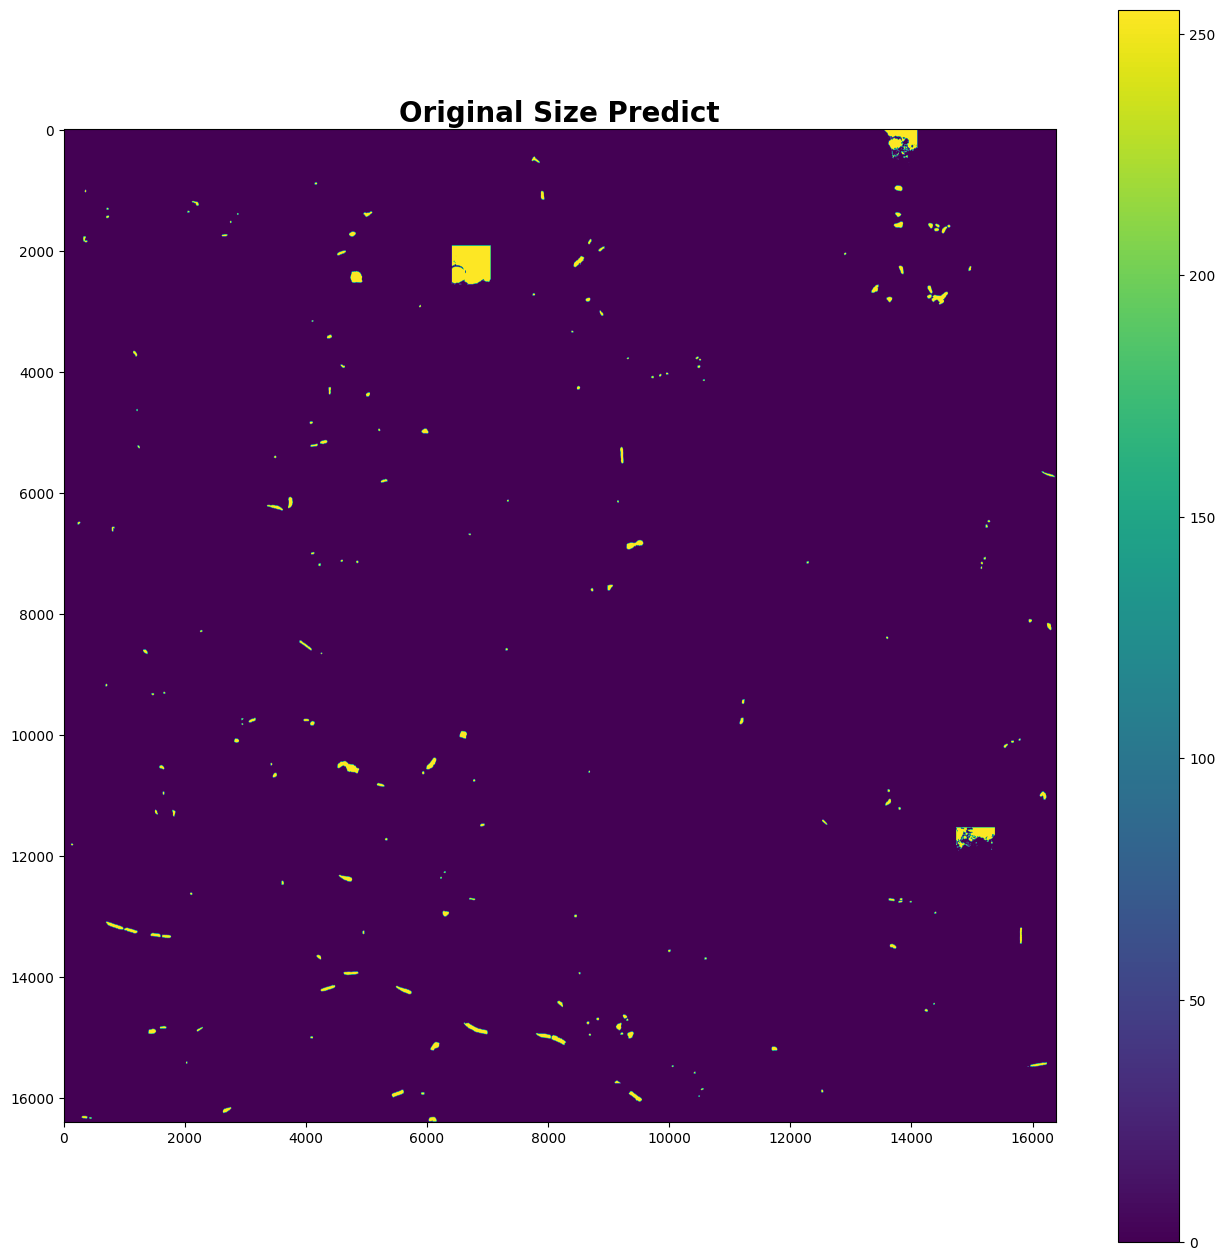

In [16]:
PATHS_PATCH = glob('/workspace/sample/train_scale1_h640_w640_oh0.0_ow0.0_min1_segs/*.tif') 
print('Num Patch', len(PATHS_PATCH))

pred_org = np.zeros(img_org.shape[1:], dtype=np.uint8)
print(pred_org.shape)

for _P in tqdm(PATHS_PATCH, total=len(PATHS_PATCH)):
    ranges = _P.split('/')[-1].split('_')[-4:]
    crop_range_x_min = int(ranges[0])
    crop_range_x_max = int(ranges[2])
    crop_range_y_min = int(ranges[1])
    crop_range_y_max = int(ranges[3].replace('.tif', ''))
    
    pred = cv2.imread(_P.replace('.tif', '.png'), cv2.IMREAD_UNCHANGED)
    if pred is None:
        continue
    
    pred_org[crop_range_y_min:crop_range_y_max, crop_range_x_min:crop_range_x_max] = pred

plt.figure(figsize=(16, 16), facecolor='white')
plt.title('Original Size Predict', fontsize=20, fontweight='bold')
plt.imshow(pred_org);
plt.colorbar()

PATH_PRED_NO_GEO_TIF = '/workspace/sample/pred.tif'
tifffile.imwrite(PATH_PRED_NO_GEO_TIF, pred_org)

In [17]:
PATH_GEO = PATH_PRED_NO_GEO_TIF.replace('.tif', '_geo.tif')
with rasterio.open(PATH_PRED_NO_GEO_TIF) as geo_non:
    output_tiff = geo_non.read(1)

with rasterio.open(PATH_ORG, 'r') as info:
    with rasterio.open(
                    PATH_GEO, 
                    'w', 
                    driver='GTiff', 
                    height=info.shape[0], 
                    width=info.shape[1], 
                    count=1, 
                    dtype=output_tiff.dtype, 
                    crs=info.crs, 
                    transform=info.transform) as out_info:

        out_info.write(output_tiff, 1)

/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
